In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest
from unsupervised_bias_detection.cluster import BiasAwareHierarchicalKModes

#### A. Load data and data preparation

##### A.1 Load data

In [2]:
# Load the COMPAS dataset
file_path = "./compas-scores-two-years.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


##### A.2 Data cleaning

In [3]:
# Check for missing values
print(df.isnull().sum())

# Select relevant columns
columns_of_interest = ["age_cat", "sex", "race", "c_charge_degree", "is_recid", "score_text"]
filtered_df = df[columns_of_interest]

# Drop rows with missing values
filtered_df = filtered_df.dropna()

filtered_df.head()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

,age_cat,sex,race,c_charge_degree,is_recid,score_text
0,Greater than 45,Male,Other,F,0,Low
1,25 - 45,Male,African-American,F,1,Low
2,Less than 25,Male,African-American,F,1,Low
3,Less than 25,Male,African-American,F,0,High
4,25 - 45,Male,Other,F,0,Low


**UI text #0** (only demo)

**Information about demo dataset**

As a demo, the [COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) dataset](https://github.com/propublica/compas-analysis/tree/master) is loaded. The dataset contains features about criminal defendants and their risk of recidivism as predicted by the COMPAS algorithm. It includes demographic details such as age, sex, and race, as well as criminal history, charge details, and the predicted risk label. This dataset is as a benchmark for studying algorithmic discrimination. A description of all variables can be found in the table below.

**Variable description**
| Variable name   | Description                                 | Values                                                                 |
|-----------------|---------------------------------------------|------------------------------------------------------------------------|
| age_cat         | Age category                                | Less than 25, 25-45, Greater than 45                                   |
| sex             | Sex                                         | Male, Female                                                           |
| race            | Race                                        | African-American, Asian, Caucasian,  Hispanic, Native American, Other  |
| c_charge_degree | Severity level of the criminal charge       | M: Misdemeanor – Less severe offenses, F: Felony – More serious crimes |
| is_recid        | If defendant reoffended                     | 0: No, 1: Yes                                                          |
| score_text      | Predicted risk label of defendant           | 0: Not high risk, 1: High risk                                         |
| false_positive  | Defendant predicted to reoffend, but didn't | 0: no FP, 1: FP                                                        |


**UI text #1**

In this example, we analyze which group is most adversely affected by the risk prediction algorithm. We do this by applying the clustering algorithm on the dataset previewed below. The column `is_recid` indicates whether a defendant reoffended or not (1: yes, 0: no). The `score_text` column indicates whether a defendant was predicted to reoffend (1: yes, 0: no). The column `false_positive` (FP) represents cases where a defendant was predicted to reoffended by the algorithm, but didn't do so (1: FP, 0: no FP). A preview of the data can be found below. The column `false_positive` is used as the `bias variable`.

**1. Preview of data**

[below table with top-5 rows]

In [4]:
# map bias score (score text) to binary values
filtered_df["score_text"] = filtered_df["score_text"].map(lambda x: 1 if x == "High" else 0)
filtered_df["is_recid"] = filtered_df["is_recid"].astype("category")

# Create a false_positive column
filtered_df["false_positive"] = ((filtered_df["is_recid"] == 0) & (filtered_df["score_text"] == 1))

# Assign bias variable
bias_variable = "false_positive"

# Display the updated dataframe
filtered_df.head()

,age_cat,sex,race,c_charge_degree,is_recid,score_text,false_positive
0,Greater than 45,Male,Other,F,0,0,False
1,25 - 45,Male,African-American,F,1,0,False
2,Less than 25,Male,African-American,F,1,0,False
3,Less than 25,Male,African-American,F,0,1,True
4,25 - 45,Male,Other,F,0,0,False


Encode to original format (only for categorical data)

In [6]:
# Apply OrdinalEncoder to the categorical columns except bias variable column
encoder = OrdinalEncoder()
columns_to_encode = [col for col in filtered_df.columns if col != bias_variable]
filtered_df[columns_to_encode] = encoder.fit_transform(filtered_df[columns_to_encode])

# Display the transformed DataFrame
filtered_df.head()

,age_cat,sex,race,c_charge_degree,is_recid,score_text,false_positive
0,1.0,1.0,5.0,0.0,0.0,0.0,False
1,0.0,1.0,0.0,0.0,1.0,0.0,False
2,2.0,1.0,0.0,0.0,1.0,0.0,False
3,2.0,1.0,0.0,0.0,0.0,1.0,True
4,0.0,1.0,5.0,0.0,0.0,0.0,False


In [7]:
filtered_df.dtypes

age_cat            float64
sex                float64
race               float64
c_charge_degree    float64
is_recid           float64
score_text         float64
false_positive        bool
dtype: object

##### A.3 Explanatory data analysis

In [8]:
# for this notebook only
dim = filtered_df.shape
print(dim)
n = dim[0]

(7214, 7)


**UI text #2**

**2. Hyperparameters selected for clustering**

- Number of iterations: {n_iter}
- Minimal cluster size: {n_iter}
- Bias variable: {bias_score}
- Data type: {type_of_data}
- Bias variable interpretation: {bias_variable_interpretation}

#### B. Split dataset in train and test set

Only multiply by -1 if "Lower value of bias score is better" box in web app is ticked, becuase HBAC implementation in the package assumes that higher `y` is better.

In [9]:
# Multiply bias variable with -1 if "Lower value of bias score is better", multiply by 1 if "Higher value of bias score is better"
interpretationScalar = -1

# bias score is negated because HBAC implementation in the package assumes that higher bias variable is better
filtered_df[bias_variable] = filtered_df[bias_variable] * interpretationScalar

# split the data into training and testing sets
train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

# train data
X_train = train_df.drop(columns=[bias_variable])
y_train = train_df[bias_variable]

# test data, remove the bias score from the test set to prevent issues with decoding later
X_test = test_df.drop(columns=[bias_variable])
y_test = test_df[bias_variable]

# display the shapes of the resulting datasets
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (5771, 7)
Testing set shape: (1443, 7)


**UI text #3**

**3. Splitting dataset**

To reduce the possibility that the clustering method detects noise, the dataset is split in a train (80%) and test dataset (20%). The clustering method is first fitted on the train dataset. Then, the presence of statistically significant bias in deviating clusters is evaluated using the test dataset.

- Training set shape: {train_df.shape[0]}
- Testing set shape: {test_df.shape[0]}

#### C. Fitting HBAC - kmodes

In [10]:
# n_iter (here: 3 times) and min_cluster (1% of training dataset) can be specified by the user in the web app
hbac = BiasAwareHierarchicalKModes(bahc_max_iter=3, bahc_min_cluster_size=X_train.shape[0]*0.01)
hbac.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but BiasAwareHierarchicalClustering was fitted without feature names
  warnings.warn(


BiasAwareHierarchicalKModes(bahc_max_iter=3, bahc_min_cluster_size=57.71)

In [11]:
# number of clusters
hbac.n_clusters_

3

In [12]:
# bias score scores
hbac.scores_

array([ 0.05290941, -0.02457072, -0.05428006])

In [13]:
# number of datapoints is cluster, user can specify cluster label (here cluster_label=0)
cluster_label = 0 # specified by user
n_cluster = np.sum(hbac.labels_ == cluster_label)
print(f"Number of datapoints in cluster {cluster_label}: {n_cluster}/{train_df.shape[0]}")

Number of datapoints in cluster 0: 4626/5771


**UI text #4**

**4. Clustering results**

- Number of clusters detected: {hbac.n_clusters_}
- Number of datapoints in cluster with most bias: {n_most_bias}/{train_df.shape[0]}

In [14]:
# assign cluster label to the test set, based on results from the training set
cluster_label_X_test = hbac.predict(X_test.to_numpy())
cluster_label_X_test

array([0, 0, 2, ..., 0, 0, 1], dtype=uint32)

Decode to original format (only for categorical data)

In [15]:
# decode X_test using the encoder
test_df_pred = test_df[columns_to_encode]
decoded_X_test = encoder.inverse_transform(test_df_pred)

# display the decoded DataFrame
decoded_X_test = pd.DataFrame(decoded_X_test, columns=test_df_pred.columns)
decoded_X_test

,age_cat,sex,race,c_charge_degree,is_recid,score_text
0,Greater than 45,Male,Caucasian,F,0,0
1,25 - 45,Male,African-American,M,0,0
2,Greater than 45,Male,African-American,M,1,0
3,Less than 25,Male,African-American,F,1,1
4,25 - 45,Female,Other,M,0,0
...,...,...,...,...,...,...
1438,Greater than 45,Male,African-American,M,1,0
1439,25 - 45,Female,Caucasian,F,0,0
1440,25 - 45,Male,Caucasian,F,0,0
1441,25 - 45,Male,Caucasian,F,1,0


#### D. Assigning cluster labels and bias_variable to test set

In [16]:
# attach bias variable again to the decoded test set (only for categorical data)
decoded_X_test[bias_variable] = y_test.values

# attach predicted cluster label to the decoded test set
decoded_X_test["cluster_label"] = cluster_label_X_test
decoded_X_test.head()

,age_cat,sex,race,c_charge_degree,is_recid,score_text,false_positive,cluster_label
0,Greater than 45,Male,Caucasian,F,0,0,0,0
1,25 - 45,Male,African-American,M,0,0,0,0
2,Greater than 45,Male,African-American,M,1,0,0,2
3,Less than 25,Male,African-American,F,1,1,0,0
4,25 - 45,Female,Other,M,0,0,0,0


In [17]:
decoded_X_test.dtypes

age_cat            object
sex                object
race               object
c_charge_degree    object
is_recid           object
score_text         object
false_positive      int64
cluster_label      uint32
dtype: object

**UI text #5**

**5. Clustering results**

$H_0$: no difference in bias variable between the most deviating cluster and the rest of the dataset

$H_1$: difference in bias variable between the most deviating cluster and the rest of the dataset

A one-sided Z-test is performed to accept or reject $H_0$.

In [18]:
# Filter decoded_X_test to only include rows with the most biased cluster label
most_biased_cluster_df = decoded_X_test[decoded_X_test["cluster_label"] == 0]
rest_df = decoded_X_test[decoded_X_test["cluster_label"] != 0]

In [19]:
# most disavanteagous bias variable is always minimum value of the bias variable
most_biased_cluster_label = most_biased_cluster_df[bias_variable].min()

# Perform Z-test for proportions
most_biased_count = (most_biased_cluster_df[bias_variable] == most_biased_cluster_label).sum()
most_biased_total = len(most_biased_cluster_df)
rest_count = (rest_df[bias_variable] == most_biased_cluster_label).sum()
rest_total = len(rest_df)

# Perform two-proportion z-test
counts = np.array([most_biased_count, rest_count])
nobs = np.array([most_biased_total, rest_total])

z_stat, p_val = proportions_ztest(counts, nobs, alternative='larger')

print(f"The label indicating the most disavanteagous bias: {most_biased_cluster_label}")
print(f"Most biased cluster in test set: {most_biased_count}/{most_biased_total} ({most_biased_count/most_biased_total:.3f})")
print(f"Rest of test set: {rest_count}/{rest_total} ({rest_count/rest_total:.3f})")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("The bias variable occurs statistically significant more often than in the rest of the dataset.")
else:
    print("The bias variable doesn't occur statistically significant more often than in the rest of the dataset.")

The label indicating the most disavanteagous bias: -1
Most biased cluster in test set: 83/1169 (0.071)
Rest of test set: 4/274 (0.015)
Z-statistic: 3.5304
P-value: 0.0002
The bias variable occurs statistically significant more often than in the rest of the dataset.


**UI text #6**

**6. Cluster differences wrt. features**

[if p<0.05] The most biased cluster has a significantly higher average bias score compared to the rest of the dataset. Use the figures below to examine the characteristics of this cluster. [4. Visualization should be shown]

- show accordion 1 + 2

[if p≥0.05] There is no significant difference in the average bias score between the most biased cluster and the rest of the dataset. There is no evidence that certain groups are more frequently associated with the bias score than others. [4. Visualization shouldn't be shown]

- don't show accordion 1 + 2

**Accordion 'Features per cluster'**

[if p<0.05]

**UI text #7**

Select a column to show cluster distribution for:

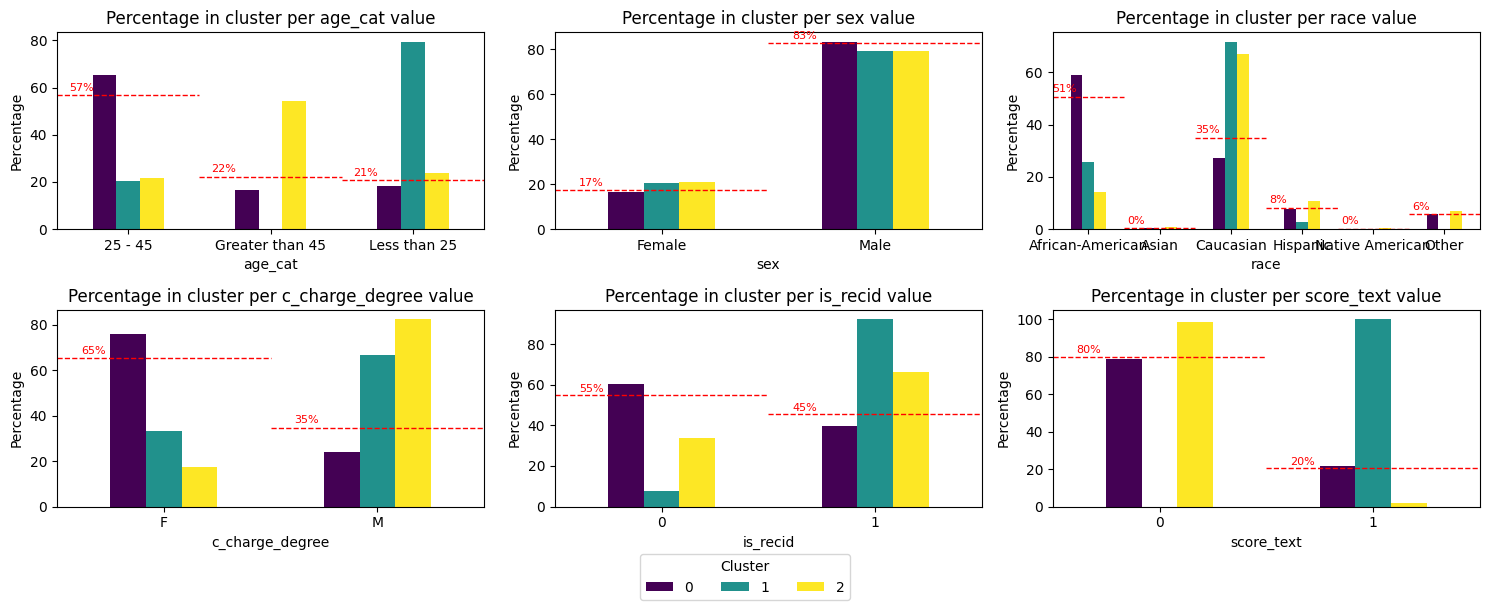

In [20]:
# Group by cluster_label and count the occurrences
df = decoded_X_test
cluster_counts = df["cluster_label"].value_counts()

# Create subplots for each column
columns_to_analyze = df.columns.drop(['cluster_label', bias_variable]) # exclude cluster_label and bias variable
rows = (len(columns_to_analyze) + 2) // 3  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, min(len(columns_to_analyze), 3), figsize=(15, 3 * rows), squeeze=False)
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, column in enumerate(columns_to_analyze):
    # Group by cluster_label and the column, then calculate percentages
    grouped_data = df.groupby(["cluster_label", column]).size().unstack(fill_value=0)
    percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
    
    # Plot the percentage data without legend
    percentages.T.plot(kind="bar", ax=axes[i], colormap="viridis", legend=False)
    axes[i].set_title(f"Percentage in cluster per {column} value")
    axes[i].set_ylabel("Percentage")
    axes[i].set_xticklabels(percentages.T.index, rotation=0)
    
    # Calculate and plot the average percentage in the entire dataset for each category value
    overall_counts = df[column].value_counts(normalize=True) * 100
    for cat_value, avg_pct in overall_counts.items():
        # Find the x position for this category value
        try:
            x_pos = list(percentages.T.index).index(cat_value)
        except ValueError:
            continue  # skip if category not present in this cluster
        axes[i].axhline(y=avg_pct, xmin=x_pos / len(percentages.T.index), xmax=(x_pos + 1) / len(percentages.T.index),
                        linestyle='--', color='red', linewidth=1)
        axes[i].text(
            x=x_pos-0.33,
            y=avg_pct + 1,
            s=f"{avg_pct:.0f}%",
            color='red',
            fontsize=8,
            ha='center',
            va='bottom'
        )

# Adjust layout and show a single legend below the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.02), title='Cluster')
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

#### F. Testing statistical significance for features of most deviating cluster 

In [21]:
# perform Chi-squared test for categorical data

def chi2_test_on_cluster(decoded_X_test, bias_score, cluster_label):

    # prepare results dictionary
    chi2_results = {}

    # filter the decoded_X_test dataframe for the specified cluster label and the rest of the dataset
    cluster_df = decoded_X_test[decoded_X_test["cluster_label"] == cluster_label]
    rest_df = decoded_X_test[decoded_X_test["cluster_label"] != cluster_label]

    # number of columns in dataset excluding bias variable and cluster_label
    p = decoded_X_test.columns.shape[0] - 2

    # Bonferroni correction for multiple comparisons
    alpha = 0.05
    alpha_adj = alpha/(p-2)

    for column in decoded_X_test.drop(columns=[bias_score, "cluster_label"]).columns:
        for value in list(decoded_X_test[column].unique()):
            
            # create a 2x2 contingency table for this value: rows = [cluster_label, rest], columns = [value present, value absent]
            cluster_count = (cluster_df[column] == value).sum()
            rest_count = (rest_df[column] == value).sum()
            cluster_not = (cluster_df[column] != value).sum()
            rest_not = (rest_df[column] != value).sum()

            # create the contingency table
            contingency_table = np.array([[cluster_count, cluster_not],
                                        [rest_count, rest_not]])
            
            # calculate the difference in proportions
            cluster_perc = cluster_count / (cluster_df[column] == value).shape[0]
            rest_perc = rest_count / (rest_df[column] == value).shape[0]
            diff = cluster_perc - rest_perc

            # perform Chi-squared test
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            chi2_results[(column, value)] = {
                "chi2": chi2,
                "p_val": p,
                "dof": dof,
                "observed": contingency_table,
                "diff": diff,
                "direction": "higher" if diff > 0 else "lower",
                "abs_perc_dev": np.abs(cluster_count / (cluster_count + rest_count) - rest_count / (cluster_count + rest_count)) * 100
            }

    # print if any statistically significant differences in most deviating cluster vs the rest of the dataset was found or not
    print("alpha_adj:", alpha_adj)
    if any(res['p_val'] < alpha_adj for res in chi2_results.values()):
        print(f"\033[92mStatistically significant differences in frequency found:\033[0m")
    else:
        print(f"\033[91mNo statistically significant differences in means found.\033[0m")

    # if significant differences were found, print the variables with their differences
    for var, res in chi2_results.items():
        if res['p_val'] < alpha_adj:
            direction = res['direction']
            if direction == "higher":
                print(f"\033[92m{var[0]}: '{var[1]}' in the most deviating cluster occurs more often than in the rest of the dataset.\033[0m")
            else:
                print(f"\033[92m{var[0]}: '{var[1]}' in the most deviating cluster occurs less often than in the rest of the dataset.\033[0m")
        else:
            print(f"{var[0]}: '{var[1]}' doesn't occur statistically significant more or less often than in the rest of the dataset.\033[0m")

**Accordion 'Statistical significant difference wrt. cluster features'**

[if p<0.05]

**UI text #8**

The following statistical test is conducted for each feature:

$H_0$: feature doesn't occur more often in most deviating cluster compared to the rest of the dataset

$H_1$: feature does occur more often in most deviating cluster compared to the rest of the dataset

For categorical data a two-sided chi-squared-test, while for numerical data a two-sided t-test is used. To account for multiple hypothesis testing Bonferroni correction is applied.

In [22]:
# statistical testing results for most deviating cluster (label=0)
chi2_test_on_cluster(decoded_X_test, bias_variable, cluster_label=0)

alpha_adj: 0.0125
Statistically significant differences in frequency found:
age_cat: 'Greater than 45' in the most deviating cluster occurs less often than in the rest of the dataset.
age_cat: '25 - 45' in the most deviating cluster occurs more often than in the rest of the dataset.
age_cat: 'Less than 25' in the most deviating cluster occurs less often than in the rest of the dataset.
sex: 'Male' doesn't occur statistically significant more or less often than in the rest of the dataset.
sex: 'Female' doesn't occur statistically significant more or less often than in the rest of the dataset.
race: 'Caucasian' in the most deviating cluster occurs less often than in the rest of the dataset.
race: 'African-American' in the most deviating cluster occurs more often than in the rest of the dataset.
race: 'Other' doesn't occur statistically significant more or less often than in the rest of the dataset.
race: 'Hispanic' doesn't occur statistically significant more or less often than in the re

#### G. Conclusion

**UI text #9**

**7. Conclusion and bias report**

[Download]

**8. More information**
- [Scientific article](https://arxiv.org/pdf/2502.01713)
- [Github repository](https://github.com/NGO-Algorithm-Audit/unsupervised-bias-detection)